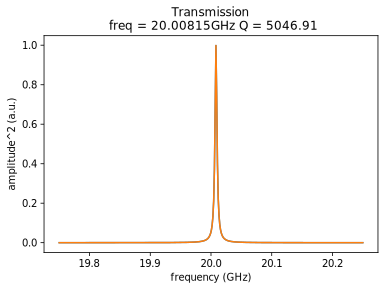

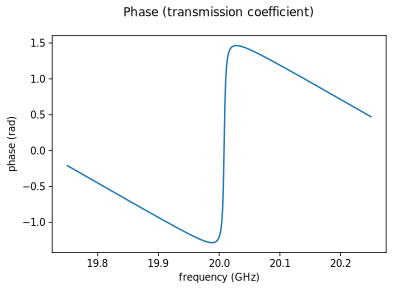

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np
import h5py
import matplotlib.pyplot as plt
import subprocess
import scipy.constants as constants
import scipy.optimize

# This considerably reduces the size of the svg data
plt.rcParams['svg.fonttype'] = 'none'

h5_file = h5py.File('results.h5', 'r')
data = h5_file['data']

# Gaussian function that we use to fit the resonance
def resonance_f(freq, freq_m, quality_factor, max_amplitude):
    omega = 2 * constants.pi * freq
    omega_m = 2 * constants.pi * freq_m
    gamma = omega_m / quality_factor
    return max_amplitude * omega_m**2 * gamma**2 / (((omega_m**2 - omega**2)**2 + gamma**2 * omega**2))

frequency = data['displacement']['frequency'][...]
# Average the probe points
displacement = np.mean(data['displacement']['displacement'], axis=0)
calibration_displacement = np.mean(data['calibration']['displacement'], axis=0)
reflection_coefficient = displacement / calibration_displacement
reflectivity = (np.abs(np.mean(data['displacement']['displacement'][...]**2, axis=0))/
                np.abs(np.mean(data['calibration']['displacement'][...]**2, axis=0)))

try:
    x_data = frequency
    y_data = reflectivity
    quality_factor_guess = 1e3
    freq_guess = x_data[np.argmax(y_data)]
    amplitude_guess = np.max(y_data)
    fit_result, covariance = scipy.optimize.curve_fit(resonance_f, x_data, y_data,
                                                      [freq_guess, quality_factor_guess, amplitude_guess])
    freq_m = fit_result[0]
    quality_factor = np.abs(fit_result[1])
    max_amplitude = fit_result[2]
    y_data_fit = resonance_f(x_data, freq_m, quality_factor, max_amplitude)

    fig = plt.figure()
    plt.plot(frequency / 1e9, reflectivity, frequency / 1e9, y_data_fit)
    plt.xlabel('frequency (GHz)')
    plt.ylabel('amplitude^2 (a.u.)')
    plt.title('Transmission\n' + 'freq = ' + "%.7g" % (freq_guess / 1e9) + 'GHz Q = ' + "%.6g" % quality_factor)
except:
    fig = plt.figure()
    plt.plot(frequency / 1e9, reflectivity)
    plt.xlabel('frequency (GHz)')
    plt.ylabel('amplitude^2 (a.u.)')
    plt.title('Transmission')

fig = plt.figure()
plt.plot(frequency / 1e9, np.angle(reflection_coefficient))
plt.xlabel('frequency (GHz)')
plt.ylabel('phase (rad)')
plt.title('Phase (transmission coefficient)\n')

plt.show()
h5_file.close()